# Project 4 - Book 1: Predict West Nile Virus

## Problem Statement

Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE) is a government body dedicated to protecting its people from infectious diseases. We have been asked to consult and generate insights on WHEN and WHERE, the Department of Public Health (DOPH) should conduct vector control to prevent the spread of the West Nile Virus (WNV). 

To do so,  we will be looking at the traps, weather and spray datasets, conduct exploratory data analysis and finally, build a classifier that is able to predict which areas will have the presence of the WNV. We will be evaluating our success using several classification metrics including, sensitivity, recall, f1 score and the ROC AUC. 

Due to the high cost of vector control, our ability to identify high risks areas through our classifier and weigh the pros and cons through a cost benefit analysis will allow the DOPH to make a calculated and informed decision. 


## Executive Summary

DATA-SCIENCE has been invited as a consultant to DOPH to help determine the most cost efficient way to implement vector control, to curb the rise of WNV. To do so, we have built a classifier to predict areas with high risks of a resurgence. 

Our classifier was successful in predicting at an above 80% ROC AUC score. We have also included 3rd party research on the costs of vector control, treatment as well as costs to the economy in terms of productivity. These will help us in our cost benefit analysis and deploy the most effective plan to deploy pesticudes throughout the city. 


## Notebooks:
- [Data Import and Cleaning](./book1_train_test_data_import_cleaning.ipynb)
- [EDA](./book2_eda.ipynb)
- [Feature Engineering, Modeling and Recommendations](./book3_feature_engineering_modeling.ipynb)


## Contents:
- [Import Libraries](#Import-Libraries)
- [Data Cleaning](#Data-Cleaning)
- [Combine with Weather Data](#Combine-with-weather-data)
- [Split Train and Test data](#Split-Train-and-Test-data)
- [Export to CSV](#Export-to-CSV)

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%matplotlib inline
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Import Data

In [2]:
train = pd.read_csv('./assets/train.csv')
test = pd.read_csv('./assets/test.csv')
spray = pd.read_csv('./assets/spray.csv')

#mapdata = np.loadtxt('./assets/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt')

## Data Cleaning

In [3]:
print(train.shape)
test.shape

(10506, 12)


(116293, 11)

#### Merge train and test data

In [4]:
df=pd.concat([train, test], ignore_index=True,axis=0,sort=True)
df.head()

,Address,AddressAccuracy,AddressNumberAndStreet,Block,Date,Id,Latitude,Longitude,NumMosquitos,Species,Street,Trap,WnvPresent
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,NaN,41.954690,-87.800991,1.0,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,0.0
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,NaN,41.954690,-87.800991,1.0,CULEX RESTUANS,N OAK PARK AVE,T002,0.0
2,"6200 North Mandell Avenue, Chicago, IL 60646, USA",9,"6200 N MANDELL AVE, Chicago, IL",62,2007-05-29,NaN,41.994991,-87.769279,1.0,CULEX RESTUANS,N MANDELL AVE,T007,0.0
3,"7900 West Foster Avenue, Chicago, IL 60656, USA",8,"7900 W FOSTER AVE, Chicago, IL",79,2007-05-29,NaN,41.974089,-87.824812,1.0,CULEX PIPIENS/RESTUANS,W FOSTER AVE,T015,0.0
4,"7900 West Foster Avenue, Chicago, IL 60656, USA",8,"7900 W FOSTER AVE, Chicago, IL",79,2007-05-29,NaN,41.974089,-87.824812,4.0,CULEX RESTUANS,W FOSTER AVE,T015,0.0


#### Drop columns we dont need

In [5]:
#drop columns we dont need
df.drop(['Id','Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'],axis=1,inplace=True)

#### Check for null values

In [6]:
df.info()
#the null values are fine as they belong to the test set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126799 entries, 0 to 126798
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          126799 non-null  object 
 1   Latitude      126799 non-null  float64
 2   Longitude     126799 non-null  float64
 3   NumMosquitos  10506 non-null   float64
 4   Species       126799 non-null  object 
 5   Trap          126799 non-null  object 
 6   WnvPresent    10506 non-null   float64
dtypes: float64(4), object(3)
memory usage: 6.8+ MB


#### Rename Columns

In [7]:
#rename the columns
df.rename(columns={
    'Date': 'date',
    'Species': 'species',
    'Trap': 'trap',
    'Latitude': 'lat',
    'Longitude': 'lon',
    'NumMosquitos': 'num_mos',
    'WnvPresent': 'wnv_pres'    
},inplace=True)

#### Changing trap to numerical variable

In [8]:
#check the types of Trap
#since traps with a letter appended at the end are satelite traps,
# we will just refer to the numbers
df['trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

In [9]:
#make trap into numerical 
df['trap'] = df['trap'].map(lambda x: int(re.findall('\d+',x)[0]))
df['trap'].value_counts()

90     3202
218    3125
2      2562
200    2420
900    2218
54     1724
128    1694
94     1647
65     1641
9      1639
35     1592
115    1318
138    1082
8       961
135     957
151     953
11      947
212     925
903     924
114     920
158     920
48      909
31      909
73      904
3       902
28      900
30      897
27      896
209     893
12      886
102     884
74      883
221     881
47      881
159     881
66      879
63      878
220     874
13      873
46      872
225     869
82      867
147     867
61      865
223     861
80      859
33      859
152     857
89      856
145     855
95      852
160     851
86      846
155     846
49      846
69      845
62      844
79      843
103     843
16      841
39      841
227     840
144     839
17      838
83      837
226     837
148     830
230     827
228     826
18      823
231     823
43      823
235     823
222     822
233     815
224     815
232     810
96      810
99      806
215     805
81      804
153     801
45      797
236 

#### Convert 'date' to datetime

In [10]:
df['date'] = pd.to_datetime(df['date'])

#### KMeans Clustering for lat and lon

In [11]:
clus = df.loc[:,['trap','lat','lon']]
clus.head()

,trap,lat,lon
0,2,41.954690,-87.800991
1,2,41.954690,-87.800991
2,7,41.994991,-87.769279
3,15,41.974089,-87.824812
4,15,41.974089,-87.824812


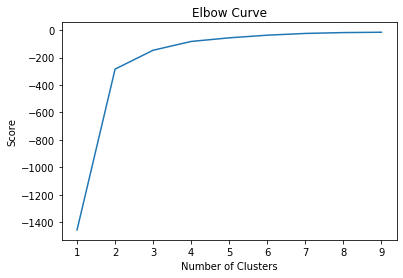

In [12]:
#if we don't know the number of stations, we can use the elbow method. 

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = clus[['lat']]
X_axis = clus[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve');

#in the plot, we can see that once the curve passes 2, 
#the increase is incremental. Therefore, we know that there are 2 stations

In [13]:
km = KMeans(n_clusters=2,init='k-means++')
km.fit(clus[clus.columns[1:3]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
clus['clus_label'] = km.fit_predict(clus[clus.columns[1:3]])
center = km.cluster_centers_
label = km.predict(clus[clus.columns[1:3]])

clus['clus_label'].value_counts()

1    65889
0    60910
Name: clus_label, dtype: int64

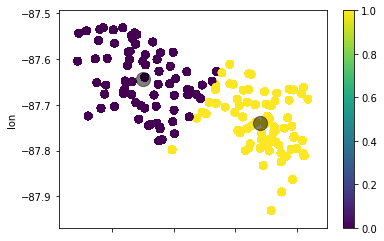

In [15]:
clus.plot.scatter(x = 'lat', y = 'lon', c=label, s=50, cmap='viridis')
plt.scatter(center[:, 0], center[:, 1], c='black', s=200, alpha=0.5)

In [16]:
#now we put it back into a df
df['station'] = clus['clus_label']

In [17]:
#convert to station 1 and 2
df['station'] = df['station'].map(lambda x: 1 if x==0 else 2)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126799 entries, 0 to 126798
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      126799 non-null  datetime64[ns]
 1   lat       126799 non-null  float64       
 2   lon       126799 non-null  float64       
 3   num_mos   10506 non-null   float64       
 4   species   126799 non-null  object        
 5   trap      126799 non-null  int64         
 6   wnv_pres  10506 non-null   float64       
 7   station   126799 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 7.7+ MB


#### Create dummies for species

In [19]:
df['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS', 'UNSPECIFIED CULEX'], dtype=object)

In [20]:
df = pd.get_dummies(df, drop_first = False)

## Combine with weather data

In [21]:
#import weather data
weather = pd.read_csv('./assets/data_clean/weather_clean.csv')

In [22]:
#let's see the data
print(weather.shape)
weather.head()

(2944, 36)


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,depth,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,ra,fg,gr,br,tsra,sn,dz,fg+,sq,fu,hz,mifg,vcfg,bcfg,vcts,ts
0,1,2007-05-01,83,50,67,14,51,56,0,2,448,1849,0,0.0,0.0,29.10,29.82,1.7,27,9.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68,14,51,57,0,3,448,1849,0,0.0,0.0,29.18,29.82,2.7,25,9.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51,-3,42,47,14,0,447,1850,0,0.0,0.0,29.38,30.09,13.0,4,13.4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2,2007-05-02,60,43,52,-3,42,47,13,0,447,1850,0,0.0,0.0,29.44,30.08,13.3,2,13.4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,2007-05-03,66,46,56,2,40,48,9,0,446,1851,0,0.0,0.0,29.39,30.12,11.7,7,11.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
weather['date'] = pd.to_datetime(weather['date'])

In [24]:
df_weather = pd.merge(df, weather, on=['date','station'],how='left')
df_weather.columns

Index(['date', 'lat', 'lon', 'num_mos', 'trap', 'wnv_pres', 'station',
       'species_CULEX ERRATICUS', 'species_CULEX PIPIENS',
       'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS',
       'species_CULEX SALINARIUS', 'species_CULEX TARSALIS',
       'species_CULEX TERRITANS', 'species_UNSPECIFIED CULEX', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise',
       'sunset', 'depth', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'ra', 'fg', 'gr', 'br', 'tsra',
       'sn', 'dz', 'fg+', 'sq', 'fu', 'hz', 'mifg', 'vcfg', 'bcfg', 'vcts',
       'ts'],
      dtype='object')

In [25]:
#check for null values
print(df_weather.shape)
df_weather.isnull().sum()

(126799, 49)


date                                   0
lat                                    0
lon                                    0
num_mos                           116293
trap                                   0
wnv_pres                          116293
station                                0
species_CULEX ERRATICUS                0
species_CULEX PIPIENS                  0
species_CULEX PIPIENS/RESTUANS         0
species_CULEX RESTUANS                 0
species_CULEX SALINARIUS               0
species_CULEX TARSALIS                 0
species_CULEX TERRITANS                0
species_UNSPECIFIED CULEX              0
tmax                                   0
tmin                                   0
tavg                                   0
depart                                 0
dewpoint                               0
wetbulb                                0
heat                                   0
cool                                   0
sunrise                                0
sunset          

## Split Train and Test data

In [26]:
#split test data
test_clean = df_weather[df_weather['num_mos'].isnull()]

In [27]:
#check test data
print(test_clean.shape)
test_clean.head()

(116293, 49)


,date,lat,lon,num_mos,trap,wnv_pres,station,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,depth,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,ra,fg,gr,br,tsra,sn,dz,fg+,sq,fu,hz,mifg,vcfg,bcfg,vcts,ts
10506,2008-06-11,41.95469,-87.800991,NaN,2,NaN,2,0,0,1,0,0,0,0,0,86,66,76,7,55,64,0,11,416,1926,0,0.0,0.0,29.34,29.97,9.4,18,10.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10507,2008-06-11,41.95469,-87.800991,NaN,2,NaN,2,0,0,0,1,0,0,0,0,86,66,76,7,55,64,0,11,416,1926,0,0.0,0.0,29.34,29.97,9.4,18,10.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10508,2008-06-11,41.95469,-87.800991,NaN,2,NaN,2,0,1,0,0,0,0,0,0,86,66,76,7,55,64,0,11,416,1926,0,0.0,0.0,29.34,29.97,9.4,18,10.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10509,2008-06-11,41.95469,-87.800991,NaN,2,NaN,2,0,0,0,0,1,0,0,0,86,66,76,7,55,64,0,11,416,1926,0,0.0,0.0,29.34,29.97,9.4,18,10.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10510,2008-06-11,41.95469,-87.800991,NaN,2,NaN,2,0,0,0,0,0,0,1,0,86,66,76,7,55,64,0,11,416,1926,0,0.0,0.0,29.34,29.97,9.4,18,10.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
#split train data
train_clean=df_weather[~df_weather['num_mos'].isnull()]

In [29]:
#check test data
print(train_clean.shape)
train_clean.head()

(10506, 49)


,date,lat,lon,num_mos,trap,wnv_pres,station,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,depth,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,ra,fg,gr,br,tsra,sn,dz,fg+,sq,fu,hz,mifg,vcfg,bcfg,vcts,ts
0,2007-05-29,41.954690,-87.800991,1.0,2,0.0,2,0,0,1,0,0,0,0,0,88,65,77,10,59,66,0,12,421,1917,0,0.0,0.0,29.44,30.09,5.8,16,7.4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,2007-05-29,41.954690,-87.800991,1.0,2,0.0,2,0,0,0,1,0,0,0,0,88,65,77,10,59,66,0,12,421,1917,0,0.0,0.0,29.44,30.09,5.8,16,7.4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,2007-05-29,41.994991,-87.769279,1.0,7,0.0,2,0,0,0,1,0,0,0,0,88,65,77,10,59,66,0,12,421,1917,0,0.0,0.0,29.44,30.09,5.8,16,7.4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,2007-05-29,41.974089,-87.824812,1.0,15,0.0,2,0,0,1,0,0,0,0,0,88,65,77,10,59,66,0,12,421,1917,0,0.0,0.0,29.44,30.09,5.8,16,7.4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,2007-05-29,41.974089,-87.824812,4.0,15,0.0,2,0,0,0,1,0,0,0,0,88,65,77,10,59,66,0,12,421,1917,0,0.0,0.0,29.44,30.09,5.8,16,7.4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


#### Condense the num of mosquitos
Because each row only contains 50 mosquitos, we want to condense the data into their respective rows

In [30]:
#we can see that there are many rows with exactly 50 mosquitos 
train_clean['num_mos'].value_counts().head(10)

1.0     2307
2.0     1300
50.0    1019
3.0      896
4.0      593
5.0      489
6.0      398
7.0      326
8.0      244
9.0      237
Name: num_mos, dtype: int64

In [31]:
train_clean = train_clean.groupby([col for col in train_clean.columns if col not in ['num_mos', 'wnv_pres']]).sum()
train_clean.reset_index(inplace=True)
train_clean['wnv_pres'] = train_clean['wnv_pres'].map(lambda x : 1 if x > 0 else x)

In [32]:
train_clean['num_mos'].value_counts().head(10)

1.0     2113
2.0     1171
3.0      803
4.0      540
5.0      432
6.0      365
7.0      302
8.0      210
9.0      206
10.0     178
Name: num_mos, dtype: int64

In [33]:
#condensed 10506 rows to 8475 rows 
train_clean.shape

(8475, 49)

## Export to CSV

In [34]:
#export clean data with dummies as csv file
train_clean.to_csv('./assets/data_clean/train_clean.csv', index=False)
test_clean.to_csv('./assets/data_clean/test_clean.csv', index=False)